In [121]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import StratifiedShuffleSplit
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, Input, BatchNormalization
from tensorflow.keras.optimizers import SGD, RMSprop, Adam, Adadelta, Adagrad, Adamax, Nadam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.utils import to_categorical
# Callbacks
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
# Visualization
import matplotlib.pyplot as plt

import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from os.path import join,basename
import requests, zipfile, re
from glob import glob
import pandas as pd
import tifffile
import datetime, os,io
from tqdm import tqdm
import shutil

%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [122]:
#Get file names
with zipfile.ZipFile('EuroSAT.zip', 'r') as f:
    names = f.namelist()

txtfiles = [x for x in names if ".jpg" in x]

In [123]:
DATASET = "2750"

LABELS = os.listdir(DATASET)
print(LABELS)


['Forest', 'River', 'Highway', 'AnnualCrop', 'SeaLake', 'HerbaceousVegetation', 'Industrial', 'Residential', 'PermanentCrop', 'Pasture']


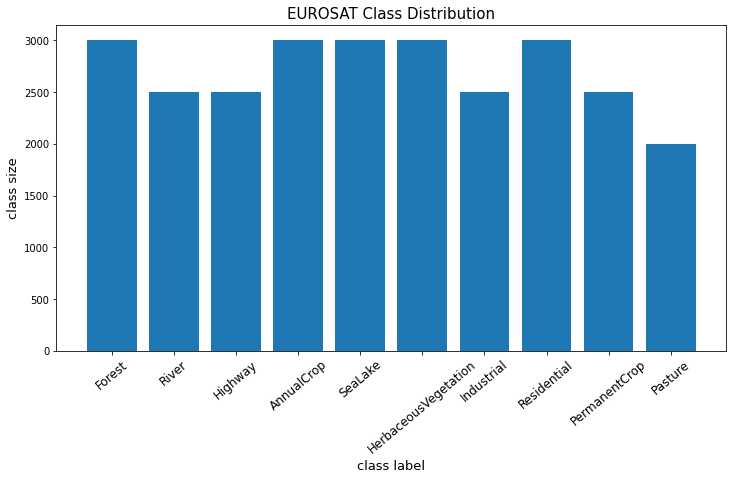

In [124]:
# plot class distributions of whole dataset
counts = {}

for l in LABELS:
    counts[l] = len(glob(join(DATASET,l,"*.jpg")))

    
plt.figure(figsize=(12, 6))

plt.bar(range(len(counts)), list(counts.values()), align='center')
plt.xticks(range(len(counts)), list(counts.keys()), fontsize=12, rotation=40)
plt.xlabel('class label', fontsize=13)
plt.ylabel('class size', fontsize=13)
plt.title('EUROSAT Class Distribution', fontsize=15);

In [125]:
TRAIN_DIR = 'EuroSAT/train'
TEST_DIR = 'EuroSAT/test'
BATCH_SIZE = 64
NUM_CLASSES=len(LABELS)
INPUT_SHAPE = (64, 64, 3)
CLASS_MODE = 'categorical'

# create training and testing directories
for path in (TRAIN_DIR, TEST_DIR):
    if not os.path.exists(path):
        os.mkdir(path)

# create class label subdirectories in train and test
for l in LABELS:
    
    if not os.path.exists(os.path.join(TRAIN_DIR, l)):
        os.mkdir(os.path.join(TRAIN_DIR, l))

    if not os.path.exists(os.path.join(TEST_DIR, l)):
        os.mkdir(os.path.join(TEST_DIR, l))


In [126]:
# map each image path to their class label in 'data'
data = {}

for l in LABELS:
    for img in os.listdir(DATASET+'/'+l):
        data.update({os.path.join(DATASET, l, img): l})

X = pd.Series(list(data.keys()))
y = pd.get_dummies(pd.Series(data.values()))

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=69)

# split the list of image paths
for train_idx, test_idx in split.split(X, y):
    
    train_paths = X[train_idx]
    test_paths = X[test_idx]

    # define a new path for each image depending on training or testing
    new_train_paths = [re.sub('2750', 'EuroSAT/train', i) for i in train_paths]
    new_test_paths = [re.sub('2750', 'EuroSAT/test', i) for i in test_paths]

    train_path_map = list((zip(train_paths, new_train_paths)))
    test_path_map = list((zip(test_paths, new_test_paths)))
    
    # move the files
    print("moving training files..")
    for i in tqdm(train_path_map):
        if not os.path.exists(i[1]):
            if not os.path.exists(re.sub('train', 'test', i[1])):
                shutil.copy(i[0], i[1])
    
    print("moving testing files..")
    for i in tqdm(test_path_map):
        if not os.path.exists(i[1]):
            if not os.path.exists(re.sub('train', 'test', i[1])):
                shutil.copy(i[0], i[1])

moving training files..


 40%|███▉      | 8630/21600 [00:00<00:00, 494215.58it/s]


FileNotFoundError: [Errno 2] No such file or directory: 'EuroSAT/train/HerbaceousVegetation/HerbaceousVegetation_EuroSAT/train.jpg'

In [127]:
DATASET = "input/EUROSAT"

LABELS = os.listdir(DATASET)
print(LABELS)


['Forest', 'River', 'Highway', 'AnnualCrop', 'SeaLake', 'HerbaceousVegetation', 'Industrial', 'Residential', 'PermanentCrop', 'Pasture']


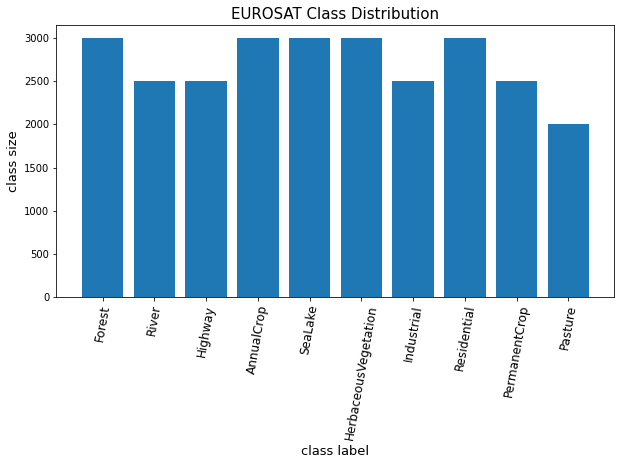

In [128]:
# plot class distributions of whole dataset
counts = {}

for l in LABELS:
    counts[l] = len(os.listdir(os.path.join(DATASET, l)))

    
plt.figure(figsize=(10, 5))

plt.bar(range(len(counts)), list(counts.values()), align='center')
plt.xticks(range(len(counts)), list(counts.keys()), fontsize=12, rotation=80)
plt.xlabel('class label', fontsize=13)
plt.ylabel('class size', fontsize=13)
plt.title('EUROSAT Class Distribution', fontsize=15);

In [129]:
import re
from sklearn.model_selection import StratifiedShuffleSplit
from keras.preprocessing.image import ImageDataGenerator

TRAIN_DIR = 'working/training'
TEST_DIR = 'working/testing'
BATCH_SIZE = 128
NUM_CLASSES=len(LABELS)
INPUT_SHAPE = (64, 64, 3)
CLASS_MODE = 'categorical'

# create training and testing directories
for path in (TRAIN_DIR, TEST_DIR):
    if not os.path.exists(path):
        os.mkdir(path)

# create class label subdirectories in train and test
for l in LABELS:
    
    if not os.path.exists(os.path.join(TRAIN_DIR, l)):
        os.mkdir(os.path.join(TRAIN_DIR, l))

    if not os.path.exists(os.path.join(TEST_DIR, l)):
        os.mkdir(os.path.join(TEST_DIR, l))

In [132]:
data = {}

for l in LABELS:
    for img in os.listdir(DATASET+'/'+l):
        data.update({os.path.join(DATASET, l, img): l})

X = pd.Series(list(data.keys()))
y = pd.get_dummies(pd.Series(data.values()))

split = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=69)

# split the list of image paths
for train_idx, test_idx in split.split(X, y):
    
    train_paths = X[train_idx]
    test_paths = X[test_idx]

    # define a new path for each image depending on training or testing
    new_train_paths = [re.sub('input\/EUROSAT', 'working/training', i) for i in train_paths]
    new_test_paths = [re.sub('input\/EUROSAT', 'working/testing', i) for i in test_paths]

    train_path_map = list((zip(train_paths, new_train_paths)))
    test_path_map = list((zip(test_paths, new_test_paths)))
    
    # move the files
    print("moving training files..")
    for i in tqdm(train_path_map):
        if not os.path.exists(i[1]):
            if not os.path.exists(re.sub('training', 'testing', i[1])):
                shutil.copy(i[0], i[1])
    
    print("moving testing files..")
    for i in tqdm(test_path_map):
        if not os.path.exists(i[1]):
            if not os.path.exists(re.sub('training', 'testing', i[1])):
                shutil.copy(i[0], i[1])



moving training files..


100%|██████████| 18900/18900 [00:04<00:00, 4668.94it/s]


moving testing files..


100%|██████████| 8100/8100 [00:01<00:00, 4526.48it/s]


In [133]:
# training generator - create one for validation subset
train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=60,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    validation_split=0.3
)

train_generator = train_gen.flow_from_directory(
    directory=TRAIN_DIR,
    target_size=(64, 64),
    batch_size=BATCH_SIZE,
    class_mode=CLASS_MODE,
    subset='training',
    color_mode='rgb',
    shuffle=True,
    seed=69
)

valid_generator = train_gen.flow_from_directory(
    directory=TRAIN_DIR,
    target_size=(64, 64),
    batch_size=BATCH_SIZE,
    class_mode=CLASS_MODE,
    subset='validation',    
    color_mode='rgb',
    shuffle=True,
    seed=69
)

# test generator for evaluation purposes - no augmentations, just rescaling
test_gen = ImageDataGenerator(
    rescale=1./255
)

test_generator = test_gen.flow_from_directory(
    directory=TEST_DIR,
    target_size=(64, 64),
    batch_size=1,
    class_mode=None,
    color_mode='rgb',
    shuffle=False,
    seed=69
)

Found 13230 images belonging to 10 classes.
Found 5670 images belonging to 10 classes.
Found 8100 images belonging to 10 classes.


In [134]:
print(train_generator.class_indices)

{'AnnualCrop': 0, 'Forest': 1, 'HerbaceousVegetation': 2, 'Highway': 3, 'Industrial': 4, 'Pasture': 5, 'PermanentCrop': 6, 'Residential': 7, 'River': 8, 'SeaLake': 9}


In [135]:
np.save('class_indices', train_generator.class_indices)

In [136]:


import tensorflow as tf
from keras.models import Model
from keras.layers import Dense
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.optimizers import Adagrad


from keras.applications.vgg16 import VGG16


from sklearn.metrics import precision_recall_fscore_support, confusion_matrix

In [137]:
# Full VGG16 model
VGG16(weights="imagenet",
      include_top=True,      
      input_shape=(224,224,3)).summary()

Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2022-06-23 23:30:55.007087: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-06-23 23:30:55.007682: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


553467096/553467096 [==============================] - 100s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                          

In [138]:
# VGG16 model without top layers (feature extractor)
VGG16(weights="imagenet",
      include_top=False,      
      input_shape=(224,224,3)).summary()

58889256/58889256 [==============================] - 122s 2us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

In [139]:
def get_vgg_model(n_classes, fine_tuning=True):
    # Pre-trained model VGG16 with ImageNet
    base_model = VGG16(weights="imagenet",
                       include_top=False,
                       input_shape=(256,256,3),
                       classes=n_classes
                       )
            
    model = Sequential([base_model,
                        Flatten(),
                        Dense(100, activation="relu"),
                        Dense(50, activation="relu"),
                        Dense(n_classes, activation="softmax")]
                       )
    
    model.compile(optimizer=SGD(learning_rate=0.001),
                  loss="categorical_crossentropy",
                  metrics=['accuracy']
                  )
    
    if fine_tuning:
        base_model.trainable = False
    else:
        model.trainable = False

    return model

In [140]:
n_classes = len(LABELS)
model_vgg16 = get_vgg_model(n_classes=n_classes, fine_tuning=False)
model_vgg16_fine_tune = get_vgg_model(n_classes=n_classes, fine_tuning=True)

model_vgg16.summary()
model_vgg16_fine_tune.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 100)               3276900   
                                                                 
 dense_1 (Dense)             (None, 50)                5050      
                                                                 
 dense_2 (Dense)             (None, 10)                510       
                                                                 
Total params: 17,997,148
Trainable params: 0
Non-trainable params: 17,997,148
_________________________________________________________________
Model: "sequential_1"
______________________

In [141]:
def compile_model(input_shape, n_classes, optimizer, fine_tune=None):
    
    conv_base = VGG16(include_top=False,
                     weights='imagenet', 
                     input_shape=input_shape,
                     pooling='avg')
    
    top_model = conv_base.output
    top_model = Dense(2048, activation='relu')(top_model)
    output_layer = Dense(n_classes, activation='softmax')(top_model)
    
    model = Model(inputs=conv_base.input, outputs=output_layer)
        
    if type(fine_tune) == int:
        for layer in conv_base.layers[fine_tune:]:
            layer.trainable = True
    else:
        for layer in conv_base.layers:
            layer.trainable = False

    model.compile(optimizer=optimizer, loss='categorical_crossentropy',
                 metrics=['categorical_accuracy'])
    
    return model

In [158]:
optim = Adagrad()
model = compile_model((64,64,3), 10, optim, fine_tune=None)
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0   

In [159]:
N_STEPS = train_generator.samples//BATCH_SIZE
N_VAL_STEPS = valid_generator.samples//BATCH_SIZE
N_EPOCHS = 100

   # model callbacks
checkpoint = ModelCheckpoint(filepath='working/model.weights.best.hdf5',
                        monitor='val_categorical_accuracy',
                        save_best_only=True,
                        verbose=1)

early_stop = EarlyStopping(monitor='val_categorical_accuracy',
                           patience=10,
                           restore_best_weights=True,
                           mode='max')

In [160]:


history = model.fit_generator(train_generator,
                             steps_per_epoch=N_STEPS,
                             epochs=N_EPOCHS,
                             callbacks=[early_stop, checkpoint],
                             validation_data=valid_generator,
                             validation_steps=N_VAL_STEPS)



Epoch 1/100


/var/folders/wm/jf5bq5r94mqgp8j4gnpmb7xw0000gn/T/ipykernel_16370/3581953124.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator,
2022-06-24 00:10:52.214151: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


103/103 [==============================] - ETA: 0s - loss: 2.1710 - categorical_accuracy: 0.2769

2022-06-24 00:11:12.844812: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_categorical_accuracy improved from -inf to 0.38814, saving model to working/model.weights.best.hdf5
103/103 [==============================] - 30s 282ms/step - loss: 2.1710 - categorical_accuracy: 0.2769 - val_loss: 2.0419 - val_categorical_accuracy: 0.3881
Epoch 2/100
103/103 [==============================] - ETA: 0s - loss: 1.9565 - categorical_accuracy: 0.4246
Epoch 2: val_categorical_accuracy improved from 0.38814 to 0.44638, saving model to working/model.weights.best.hdf5
103/103 [==============================] - 28s 276ms/step - loss: 1.9565 - categorical_accuracy: 0.4246 - val_loss: 1.8796 - val_categorical_accuracy: 0.4464
Epoch 3/100
103/103 [==============================] - ETA: 0s - loss: 1.8182 - categorical_accuracy: 0.4715
Epoch 3: val_categorical_accuracy improved from 0.44638 to 0.49379, saving model to working/model.weights.best.hdf5
103/103 [==============================] - 32s 309ms/step - loss: 1.8182 - categorical_accuracy: 0.4715 - val_loss: 1.76

In [163]:
#Test on test set
test_generator.reset()
predictions = model.predict_generator(test_generator, steps=N_VAL_STEPS)
model.evaluate_generator(test_generator, steps=N_VAL_STEPS)
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes
#Print accuracy


/var/folders/wm/jf5bq5r94mqgp8j4gnpmb7xw0000gn/T/ipykernel_16370/2326854842.py:4: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = model.predict_generator(test_generator, steps=N_VAL_STEPS)
/var/folders/wm/jf5bq5r94mqgp8j4gnpmb7xw0000gn/T/ipykernel_16370/2326854842.py:5: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  model.evaluate_generator(test_generator, steps=N_VAL_STEPS)
2022-06-24 09:33:38.738882: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [164]:
model.evaluate(test_generator, steps=N_VAL_STEPS)


44/44 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - categorical_accuracy: 0.0000e+00


[0.0, 0.0]

In [144]:
compile_model(input_shape=(64,64,3), n_classes=len(LABELS), optimizer=Adagrad()).fit_generator(train_generator,epochs=10, validation_data=valid_generator)

Epoch 1/10


/var/folders/wm/jf5bq5r94mqgp8j4gnpmb7xw0000gn/T/ipykernel_16370/2974558472.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  compile_model(input_shape=(64,64,3), n_classes=len(LABELS), optimizer=Adagrad()).fit_generator(train_generator,epochs=10, validation_data=valid_generator)
2022-06-23 23:40:11.243923: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-06-23 23:40:11.621217: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


104/104 [==============================] - ETA: 0s - loss: 2.1689 - categorical_accuracy: 0.2878

2022-06-23 23:40:32.656938: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


104/104 [==============================] - 30s 283ms/step - loss: 2.1689 - categorical_accuracy: 0.2878 - val_loss: 2.0412 - val_categorical_accuracy: 0.3827
Epoch 2/10
104/104 [==============================] - 30s 287ms/step - loss: 1.9560 - categorical_accuracy: 0.4282 - val_loss: 1.8782 - val_categorical_accuracy: 0.4242
Epoch 3/10
104/104 [==============================] - 34s 329ms/step - loss: 1.8159 - categorical_accuracy: 0.4574 - val_loss: 1.7632 - val_categorical_accuracy: 0.5150
Epoch 4/10
104/104 [==============================] - 42s 400ms/step - loss: 1.7197 - categorical_accuracy: 0.4940 - val_loss: 1.6750 - val_categorical_accuracy: 0.4674
Epoch 5/10
104/104 [==============================] - 44s 419ms/step - loss: 1.6364 - categorical_accuracy: 0.5203 - val_loss: 1.6025 - val_categorical_accuracy: 0.5293
Epoch 6/10
104/104 [==============================] - 46s 447ms/step - loss: 1.5745 - categorical_accuracy: 0.5399 - val_loss: 1.5537 - val_categorical_accuracy: 0.49

In [156]:
#Train the data on pretrained vgg16 model
model__vgg16_fine_tune = VGG16(weights="imagenet",input_shape=(64,64,3), include_top=False, classes= len(LABELS))
model_vgg16_fine_tune.compile(optimizer=Adagrad(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])



In [157]:
model_vgg16_fine_tune.fit_generator(train_generator,epochs=10, validation_data=valid_generator)


Epoch 1/10


/var/folders/wm/jf5bq5r94mqgp8j4gnpmb7xw0000gn/T/ipykernel_16370/1213506448.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_vgg16_fine_tune.fit_generator(train_generator,epochs=10, validation_data=valid_generator)
2022-06-23 23:53:19.005128: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


InvalidArgumentError: Graph execution error:

Detected at node 'categorical_crossentropy/softmax_cross_entropy_with_logits' defined at (most recent call last):
    File "/Users/arjunarora/miniforge3/envs/deep/lib/python3.10/runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/Users/arjunarora/miniforge3/envs/deep/lib/python3.10/runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "/Users/arjunarora/miniforge3/envs/deep/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/Users/arjunarora/miniforge3/envs/deep/lib/python3.10/site-packages/traitlets/config/application.py", line 972, in launch_instance
      app.start()
    File "/Users/arjunarora/miniforge3/envs/deep/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 712, in start
      self.io_loop.start()
    File "/Users/arjunarora/miniforge3/envs/deep/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "/Users/arjunarora/miniforge3/envs/deep/lib/python3.10/asyncio/base_events.py", line 600, in run_forever
      self._run_once()
    File "/Users/arjunarora/miniforge3/envs/deep/lib/python3.10/asyncio/base_events.py", line 1896, in _run_once
      handle._run()
    File "/Users/arjunarora/miniforge3/envs/deep/lib/python3.10/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/Users/arjunarora/miniforge3/envs/deep/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 504, in dispatch_queue
      await self.process_one()
    File "/Users/arjunarora/miniforge3/envs/deep/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 493, in process_one
      await dispatch(*args)
    File "/Users/arjunarora/miniforge3/envs/deep/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 400, in dispatch_shell
      await result
    File "/Users/arjunarora/miniforge3/envs/deep/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 724, in execute_request
      reply_content = await reply_content
    File "/Users/arjunarora/miniforge3/envs/deep/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "/Users/arjunarora/miniforge3/envs/deep/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/Users/arjunarora/miniforge3/envs/deep/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 2881, in run_cell
      result = self._run_cell(
    File "/Users/arjunarora/miniforge3/envs/deep/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 2936, in _run_cell
      return runner(coro)
    File "/Users/arjunarora/miniforge3/envs/deep/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/Users/arjunarora/miniforge3/envs/deep/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3135, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/Users/arjunarora/miniforge3/envs/deep/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3338, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/Users/arjunarora/miniforge3/envs/deep/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3398, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/var/folders/wm/jf5bq5r94mqgp8j4gnpmb7xw0000gn/T/ipykernel_16370/1213506448.py", line 1, in <cell line: 1>
      model_vgg16_fine_tune.fit_generator(train_generator,epochs=10, validation_data=valid_generator)
    File "/Users/arjunarora/miniforge3/envs/deep/lib/python3.10/site-packages/keras/engine/training.py", line 2260, in fit_generator
      return self.fit(
    File "/Users/arjunarora/miniforge3/envs/deep/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/Users/arjunarora/miniforge3/envs/deep/lib/python3.10/site-packages/keras/engine/training.py", line 1409, in fit
      tmp_logs = self.train_function(iterator)
    File "/Users/arjunarora/miniforge3/envs/deep/lib/python3.10/site-packages/keras/engine/training.py", line 1051, in train_function
      return step_function(self, iterator)
    File "/Users/arjunarora/miniforge3/envs/deep/lib/python3.10/site-packages/keras/engine/training.py", line 1040, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/arjunarora/miniforge3/envs/deep/lib/python3.10/site-packages/keras/engine/training.py", line 1030, in run_step
      outputs = model.train_step(data)
    File "/Users/arjunarora/miniforge3/envs/deep/lib/python3.10/site-packages/keras/engine/training.py", line 890, in train_step
      loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/Users/arjunarora/miniforge3/envs/deep/lib/python3.10/site-packages/keras/engine/training.py", line 948, in compute_loss
      return self.compiled_loss(
    File "/Users/arjunarora/miniforge3/envs/deep/lib/python3.10/site-packages/keras/engine/compile_utils.py", line 201, in __call__
      loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/Users/arjunarora/miniforge3/envs/deep/lib/python3.10/site-packages/keras/losses.py", line 139, in __call__
      losses = call_fn(y_true, y_pred)
    File "/Users/arjunarora/miniforge3/envs/deep/lib/python3.10/site-packages/keras/losses.py", line 243, in call
      return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/Users/arjunarora/miniforge3/envs/deep/lib/python3.10/site-packages/keras/losses.py", line 1787, in categorical_crossentropy
      return backend.categorical_crossentropy(
    File "/Users/arjunarora/miniforge3/envs/deep/lib/python3.10/site-packages/keras/backend.py", line 5134, in categorical_crossentropy
      return tf.nn.softmax_cross_entropy_with_logits(
Node: 'categorical_crossentropy/softmax_cross_entropy_with_logits'
Detected at node 'categorical_crossentropy/softmax_cross_entropy_with_logits' defined at (most recent call last):
    File "/Users/arjunarora/miniforge3/envs/deep/lib/python3.10/runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/Users/arjunarora/miniforge3/envs/deep/lib/python3.10/runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "/Users/arjunarora/miniforge3/envs/deep/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/Users/arjunarora/miniforge3/envs/deep/lib/python3.10/site-packages/traitlets/config/application.py", line 972, in launch_instance
      app.start()
    File "/Users/arjunarora/miniforge3/envs/deep/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 712, in start
      self.io_loop.start()
    File "/Users/arjunarora/miniforge3/envs/deep/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "/Users/arjunarora/miniforge3/envs/deep/lib/python3.10/asyncio/base_events.py", line 600, in run_forever
      self._run_once()
    File "/Users/arjunarora/miniforge3/envs/deep/lib/python3.10/asyncio/base_events.py", line 1896, in _run_once
      handle._run()
    File "/Users/arjunarora/miniforge3/envs/deep/lib/python3.10/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/Users/arjunarora/miniforge3/envs/deep/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 504, in dispatch_queue
      await self.process_one()
    File "/Users/arjunarora/miniforge3/envs/deep/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 493, in process_one
      await dispatch(*args)
    File "/Users/arjunarora/miniforge3/envs/deep/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 400, in dispatch_shell
      await result
    File "/Users/arjunarora/miniforge3/envs/deep/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 724, in execute_request
      reply_content = await reply_content
    File "/Users/arjunarora/miniforge3/envs/deep/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "/Users/arjunarora/miniforge3/envs/deep/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/Users/arjunarora/miniforge3/envs/deep/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 2881, in run_cell
      result = self._run_cell(
    File "/Users/arjunarora/miniforge3/envs/deep/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 2936, in _run_cell
      return runner(coro)
    File "/Users/arjunarora/miniforge3/envs/deep/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/Users/arjunarora/miniforge3/envs/deep/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3135, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/Users/arjunarora/miniforge3/envs/deep/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3338, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/Users/arjunarora/miniforge3/envs/deep/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3398, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/var/folders/wm/jf5bq5r94mqgp8j4gnpmb7xw0000gn/T/ipykernel_16370/1213506448.py", line 1, in <cell line: 1>
      model_vgg16_fine_tune.fit_generator(train_generator,epochs=10, validation_data=valid_generator)
    File "/Users/arjunarora/miniforge3/envs/deep/lib/python3.10/site-packages/keras/engine/training.py", line 2260, in fit_generator
      return self.fit(
    File "/Users/arjunarora/miniforge3/envs/deep/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/Users/arjunarora/miniforge3/envs/deep/lib/python3.10/site-packages/keras/engine/training.py", line 1409, in fit
      tmp_logs = self.train_function(iterator)
    File "/Users/arjunarora/miniforge3/envs/deep/lib/python3.10/site-packages/keras/engine/training.py", line 1051, in train_function
      return step_function(self, iterator)
    File "/Users/arjunarora/miniforge3/envs/deep/lib/python3.10/site-packages/keras/engine/training.py", line 1040, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/arjunarora/miniforge3/envs/deep/lib/python3.10/site-packages/keras/engine/training.py", line 1030, in run_step
      outputs = model.train_step(data)
    File "/Users/arjunarora/miniforge3/envs/deep/lib/python3.10/site-packages/keras/engine/training.py", line 890, in train_step
      loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/Users/arjunarora/miniforge3/envs/deep/lib/python3.10/site-packages/keras/engine/training.py", line 948, in compute_loss
      return self.compiled_loss(
    File "/Users/arjunarora/miniforge3/envs/deep/lib/python3.10/site-packages/keras/engine/compile_utils.py", line 201, in __call__
      loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/Users/arjunarora/miniforge3/envs/deep/lib/python3.10/site-packages/keras/losses.py", line 139, in __call__
      losses = call_fn(y_true, y_pred)
    File "/Users/arjunarora/miniforge3/envs/deep/lib/python3.10/site-packages/keras/losses.py", line 243, in call
      return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/Users/arjunarora/miniforge3/envs/deep/lib/python3.10/site-packages/keras/losses.py", line 1787, in categorical_crossentropy
      return backend.categorical_crossentropy(
    File "/Users/arjunarora/miniforge3/envs/deep/lib/python3.10/site-packages/keras/backend.py", line 5134, in categorical_crossentropy
      return tf.nn.softmax_cross_entropy_with_logits(
Node: 'categorical_crossentropy/softmax_cross_entropy_with_logits'
2 root error(s) found.
  (0) INVALID_ARGUMENT:  logits and labels must be broadcastable: logits_size=[8,10] labels_size=[128,10]
	 [[{{node categorical_crossentropy/softmax_cross_entropy_with_logits}}]]
	 [[sequential_1/dense_5/Softmax/_10]]
  (1) INVALID_ARGUMENT:  logits and labels must be broadcastable: logits_size=[8,10] labels_size=[128,10]
	 [[{{node categorical_crossentropy/softmax_cross_entropy_with_logits}}]]
0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_18745]

In [172]:
#IMport googlenet
from keras.applications.inception_resnet_v2 import InceptionResNetV2

In [178]:
model = InceptionResNetV2(weights="imagenet",input_shape=(64,64,3), include_top=False, classes= len(LABELS))

ValueError: Input size must be at least 75x75; Received: input_shape=(64, 64, 3)

In [199]:
from keras.applications.vgg19 import VGG19
model_vgg19 = VGG19(weights="imagenet",input_shape=(64,64,3), include_top=False, classes= len(LABELS), pooling='avg')

In [219]:
model_vgg19.compile(optimizer=Adagrad(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [220]:
model_vgg19.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_22 (InputLayer)       [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0     

In [221]:
train_generator.reset()

In [222]:
model_vgg19.fit_generator(train_generator,epochs=10, validation_data=valid_generator)

Epoch 1/10


/var/folders/wm/jf5bq5r94mqgp8j4gnpmb7xw0000gn/T/ipykernel_16370/2941083123.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_vgg19.fit_generator(train_generator,epochs=10, validation_data=valid_generator)
2022-06-24 13:46:21.686722: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


InvalidArgumentError: Graph execution error:

Detected at node 'categorical_crossentropy/mul' defined at (most recent call last):
    File "/Users/arjunarora/miniforge3/envs/deep/lib/python3.10/runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/Users/arjunarora/miniforge3/envs/deep/lib/python3.10/runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "/Users/arjunarora/miniforge3/envs/deep/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/Users/arjunarora/miniforge3/envs/deep/lib/python3.10/site-packages/traitlets/config/application.py", line 972, in launch_instance
      app.start()
    File "/Users/arjunarora/miniforge3/envs/deep/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 712, in start
      self.io_loop.start()
    File "/Users/arjunarora/miniforge3/envs/deep/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "/Users/arjunarora/miniforge3/envs/deep/lib/python3.10/asyncio/base_events.py", line 600, in run_forever
      self._run_once()
    File "/Users/arjunarora/miniforge3/envs/deep/lib/python3.10/asyncio/base_events.py", line 1896, in _run_once
      handle._run()
    File "/Users/arjunarora/miniforge3/envs/deep/lib/python3.10/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/Users/arjunarora/miniforge3/envs/deep/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 504, in dispatch_queue
      await self.process_one()
    File "/Users/arjunarora/miniforge3/envs/deep/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 493, in process_one
      await dispatch(*args)
    File "/Users/arjunarora/miniforge3/envs/deep/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 400, in dispatch_shell
      await result
    File "/Users/arjunarora/miniforge3/envs/deep/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 724, in execute_request
      reply_content = await reply_content
    File "/Users/arjunarora/miniforge3/envs/deep/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "/Users/arjunarora/miniforge3/envs/deep/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/Users/arjunarora/miniforge3/envs/deep/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 2881, in run_cell
      result = self._run_cell(
    File "/Users/arjunarora/miniforge3/envs/deep/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 2936, in _run_cell
      return runner(coro)
    File "/Users/arjunarora/miniforge3/envs/deep/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/Users/arjunarora/miniforge3/envs/deep/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3135, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/Users/arjunarora/miniforge3/envs/deep/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3338, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/Users/arjunarora/miniforge3/envs/deep/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3398, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/var/folders/wm/jf5bq5r94mqgp8j4gnpmb7xw0000gn/T/ipykernel_16370/2941083123.py", line 1, in <cell line: 1>
      model_vgg19.fit_generator(train_generator,epochs=10, validation_data=valid_generator)
    File "/Users/arjunarora/miniforge3/envs/deep/lib/python3.10/site-packages/keras/engine/training.py", line 2260, in fit_generator
      return self.fit(
    File "/Users/arjunarora/miniforge3/envs/deep/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/Users/arjunarora/miniforge3/envs/deep/lib/python3.10/site-packages/keras/engine/training.py", line 1409, in fit
      tmp_logs = self.train_function(iterator)
    File "/Users/arjunarora/miniforge3/envs/deep/lib/python3.10/site-packages/keras/engine/training.py", line 1051, in train_function
      return step_function(self, iterator)
    File "/Users/arjunarora/miniforge3/envs/deep/lib/python3.10/site-packages/keras/engine/training.py", line 1040, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/arjunarora/miniforge3/envs/deep/lib/python3.10/site-packages/keras/engine/training.py", line 1030, in run_step
      outputs = model.train_step(data)
    File "/Users/arjunarora/miniforge3/envs/deep/lib/python3.10/site-packages/keras/engine/training.py", line 890, in train_step
      loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/Users/arjunarora/miniforge3/envs/deep/lib/python3.10/site-packages/keras/engine/training.py", line 948, in compute_loss
      return self.compiled_loss(
    File "/Users/arjunarora/miniforge3/envs/deep/lib/python3.10/site-packages/keras/engine/compile_utils.py", line 201, in __call__
      loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/Users/arjunarora/miniforge3/envs/deep/lib/python3.10/site-packages/keras/losses.py", line 139, in __call__
      losses = call_fn(y_true, y_pred)
    File "/Users/arjunarora/miniforge3/envs/deep/lib/python3.10/site-packages/keras/losses.py", line 243, in call
      return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/Users/arjunarora/miniforge3/envs/deep/lib/python3.10/site-packages/keras/losses.py", line 1787, in categorical_crossentropy
      return backend.categorical_crossentropy(
    File "/Users/arjunarora/miniforge3/envs/deep/lib/python3.10/site-packages/keras/backend.py", line 5153, in categorical_crossentropy
      return -tf.reduce_sum(target * tf.math.log(output), axis)
Node: 'categorical_crossentropy/mul'
Detected at node 'categorical_crossentropy/mul' defined at (most recent call last):
    File "/Users/arjunarora/miniforge3/envs/deep/lib/python3.10/runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/Users/arjunarora/miniforge3/envs/deep/lib/python3.10/runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "/Users/arjunarora/miniforge3/envs/deep/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/Users/arjunarora/miniforge3/envs/deep/lib/python3.10/site-packages/traitlets/config/application.py", line 972, in launch_instance
      app.start()
    File "/Users/arjunarora/miniforge3/envs/deep/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 712, in start
      self.io_loop.start()
    File "/Users/arjunarora/miniforge3/envs/deep/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "/Users/arjunarora/miniforge3/envs/deep/lib/python3.10/asyncio/base_events.py", line 600, in run_forever
      self._run_once()
    File "/Users/arjunarora/miniforge3/envs/deep/lib/python3.10/asyncio/base_events.py", line 1896, in _run_once
      handle._run()
    File "/Users/arjunarora/miniforge3/envs/deep/lib/python3.10/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/Users/arjunarora/miniforge3/envs/deep/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 504, in dispatch_queue
      await self.process_one()
    File "/Users/arjunarora/miniforge3/envs/deep/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 493, in process_one
      await dispatch(*args)
    File "/Users/arjunarora/miniforge3/envs/deep/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 400, in dispatch_shell
      await result
    File "/Users/arjunarora/miniforge3/envs/deep/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 724, in execute_request
      reply_content = await reply_content
    File "/Users/arjunarora/miniforge3/envs/deep/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "/Users/arjunarora/miniforge3/envs/deep/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/Users/arjunarora/miniforge3/envs/deep/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 2881, in run_cell
      result = self._run_cell(
    File "/Users/arjunarora/miniforge3/envs/deep/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 2936, in _run_cell
      return runner(coro)
    File "/Users/arjunarora/miniforge3/envs/deep/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/Users/arjunarora/miniforge3/envs/deep/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3135, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/Users/arjunarora/miniforge3/envs/deep/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3338, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/Users/arjunarora/miniforge3/envs/deep/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3398, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/var/folders/wm/jf5bq5r94mqgp8j4gnpmb7xw0000gn/T/ipykernel_16370/2941083123.py", line 1, in <cell line: 1>
      model_vgg19.fit_generator(train_generator,epochs=10, validation_data=valid_generator)
    File "/Users/arjunarora/miniforge3/envs/deep/lib/python3.10/site-packages/keras/engine/training.py", line 2260, in fit_generator
      return self.fit(
    File "/Users/arjunarora/miniforge3/envs/deep/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/Users/arjunarora/miniforge3/envs/deep/lib/python3.10/site-packages/keras/engine/training.py", line 1409, in fit
      tmp_logs = self.train_function(iterator)
    File "/Users/arjunarora/miniforge3/envs/deep/lib/python3.10/site-packages/keras/engine/training.py", line 1051, in train_function
      return step_function(self, iterator)
    File "/Users/arjunarora/miniforge3/envs/deep/lib/python3.10/site-packages/keras/engine/training.py", line 1040, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/arjunarora/miniforge3/envs/deep/lib/python3.10/site-packages/keras/engine/training.py", line 1030, in run_step
      outputs = model.train_step(data)
    File "/Users/arjunarora/miniforge3/envs/deep/lib/python3.10/site-packages/keras/engine/training.py", line 890, in train_step
      loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/Users/arjunarora/miniforge3/envs/deep/lib/python3.10/site-packages/keras/engine/training.py", line 948, in compute_loss
      return self.compiled_loss(
    File "/Users/arjunarora/miniforge3/envs/deep/lib/python3.10/site-packages/keras/engine/compile_utils.py", line 201, in __call__
      loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/Users/arjunarora/miniforge3/envs/deep/lib/python3.10/site-packages/keras/losses.py", line 139, in __call__
      losses = call_fn(y_true, y_pred)
    File "/Users/arjunarora/miniforge3/envs/deep/lib/python3.10/site-packages/keras/losses.py", line 243, in call
      return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/Users/arjunarora/miniforge3/envs/deep/lib/python3.10/site-packages/keras/losses.py", line 1787, in categorical_crossentropy
      return backend.categorical_crossentropy(
    File "/Users/arjunarora/miniforge3/envs/deep/lib/python3.10/site-packages/keras/backend.py", line 5153, in categorical_crossentropy
      return -tf.reduce_sum(target * tf.math.log(output), axis)
Node: 'categorical_crossentropy/mul'
2 root error(s) found.
  (0) INVALID_ARGUMENT:  Incompatible shapes: [128,10] vs. [128,512]
	 [[{{node categorical_crossentropy/mul}}]]
	 [[Equal/_13]]
  (1) INVALID_ARGUMENT:  Incompatible shapes: [128,10] vs. [128,512]
	 [[{{node categorical_crossentropy/mul}}]]
0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_190932]

In [182]:
model_eff_net = tf.keras.applications.EfficientNetV2L(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=(None),
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
    include_preprocessing=True,
).compile(optimizer=Adagrad(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])